In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
import argparse


/home/amirsalimi/miniconda3/envs/ecg_augment/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# experiment design
- pick a dataset
- drop all labels that have less than 1000 ECG examples in the dataset
- get an equal amount of ECGs that do not have the disease (from the same dataset)
- train until no improvement is seen for 10 epochs
- best F1 for validation set is the score of the experiment

In [36]:
torch.cuda.set_device(0)
datasets = ["PTBXL","ChapmanShaoxing","CPSC2018",]
norm_type = "minmax"
max_len = 8000
sf = 0.5
scale_type = "nearest"
architecture = "inception"
DATASET_ID = "CPSC2018"
transforms = ["sc","n"]
batch_tfms = []

processing_type = '-'.join([x for x in transforms])

if "sc" in transforms:
    batch_tfms.append(tfs.Scale(scale_factor=sf,mode=scale_type))

if "n" in transforms:
    if norm_type == "minmax":
        batch_tfms.append(tfs.NormMinMax())
    if norm_type == "maxdiv":
        batch_tfms.append(tfs.NormMaxDiv())
    if norm_type == "zscore":
        batch_tfms.append(tfs.NormZScore())
    if norm_type == "median":
        batch_tfms.append(tfs.NormMedian())
    if norm_type == "deci_scale":
        batch_tfms.append(tfs.NormDecimalScaling())
        
if "bp" in transforms:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in transforms:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(transforms)==0:
    processing_type = "raw"
print("transforms:",[x.name for x in batch_tfms])
print(processing_type)

transforms: ['Scale', 'NormMinMax']
sc-n


In [66]:
# ### for all datasets, get labels that are common
# for x in ["PTBXL","ChapmanShaoxing","CPSC2018",]:
#     DATASET_ID = x
#     DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
#     X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
#     label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
#     y = snomedConvert(label_df)
#     y=y[(y.columns[y.sum()>1000])]
#     print(X.shape)
#     print(x)
#     print(y.sum())
    

In [89]:
# create an array for a label which can be used for single label classification
DATASET_ID = x
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
y = y[(y.columns[y.sum()>1000]) & (y.columns[y.sum()<0.5*len(y)])]
y

,right bundle branch block,atrial fibrillation
0,True,False
1,False,False
2,False,True
3,False,True
4,False,False
...,...,...
6872,False,False
6873,False,False
6874,False,False
6875,False,True


In [227]:
# this function takes a label, and returns a balanced dataset 
# where half the data has the label and the other does not
label = y.columns[0]
y_label = y[label]

have_index = np.array(y_label[y_label==True].index)
have_not_index = np.array(list(set(y_label.index).difference(set(have_index))))

# if have_index bigger than 50% of the total ecgs,
# then we can pick with replacement or skip (this is rare)
if len(have_index) > 0.5 * len(y_label):
    have_not_index = np.random.choice(have_not_index,len(have_index),replace=True)
else:
    have_not_index = np.random.choice(have_not_index,len(have_index),replace=False)

num_have = len(have_index)
num_have_not = len(have_not_index)
print("for %s: %s ecgs, %s have %s don't"%(label,len(y_label), num_have,num_have_not))

# this variable will contain all the indices we are interested in
selected_indices = np.concatenate([have_index,have_not_index])
selected_indices = np.sort(selected_indices)

X_sl = X[selected_indices] # X for experiment
y_sl = y_label.loc[selected_indices] # y for experiment

for right bundle branch block: 6877 ecgs, 1857 have 1857 don't


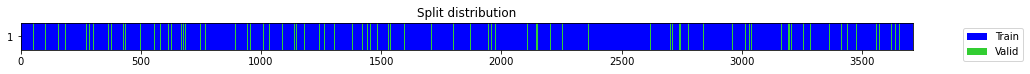

In [229]:
cv_splits = get_splits(y_sl.to_numpy()*1, n_splits =1, valid_size=.1,stratify=False, random_state=23, shuffle=True)

In [ ]:
# now we can start the experiment
tfms  = [None, TSClassification()]
dsets = TSDatasets(X_sl.astype(float)[:,:,0:max_len],  y_sl.to_numpy()*1, tfms=tfms, splits=cv_splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0, )
metrics =[F1Score()]
model = InceptionTimePlus(dls.vars, dls.c, dls.len)
# model = MiniRocketPlus(dls.vars, dls.c,dls.len)
# try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
learn = Learner(dls, model, metrics=metrics,)
learn.fit_one_cycle(300, lr_max=0.01)